In [1]:
import sys
sys.path.append("..")

import logging
import os
from argparse import ArgumentParser
from datetime import datetime as dt

import pytorch_lightning as pl
import torch
import yaml
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms
from torchvision.transforms import Compose
from torchvision.utils import make_grid, draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

from src.models.LightningBaseModel import LightningModel
from src.datamodule.DataLoader import PlanktonDataLoader
from src.lib.config import Config, register_configs
import onnxruntime as ort

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf, DictConfig
import rich
import hydra
from scipy.special import softmax
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsampler import ImbalancedDatasetSampler
from torch.utils.data import DataLoader
from shutil import copyfile
import shutil
import pandas as pd
from tqdm import tqdm

In [2]:
EXPERIMENT = "plankton/simclr_klas_linear_eval"
ONNX_FILE = "/gpfs/work/machnitz/plankton_logs/multirun/2021-10-11/14-21-17/0/logs/checkpoints/complete_model_255999.onnx"

# Load the hydra configuration:
register_configs()
with initialize(config_path="../conf"):
    config=compose(
    config_name="config", 
    overrides=[f"+experiment={EXPERIMENT}", "datamodule.batch_size=1"])

# building a rich tree from the loaded configuration:
style = "dim"
tree = rich.tree.Tree(":gear: CONFIG", style=style, guide_style=style)


for field in config.keys():
    branch = tree.add(field, style=style, guide_style=style)

    config_section = config.get(field)
    branch_content = str(config_section)
    if isinstance(config_section, DictConfig):
        branch_content = OmegaConf.to_yaml(config_section, resolve=True)

    branch.add(rich.syntax.Syntax(branch_content, "yaml"))

    
# uncomment for printing the complete loaded configuration:
# rich.print(tree)


In [3]:
# Init Transformations
train_transforms: Compose = hydra.utils.instantiate(config.datamodule.train_transforms)
valid_transforms: Compose = hydra.utils.instantiate(config.datamodule.valid_transforms)

# Init Lightning datamodule
datamodule = hydra.utils.instantiate(
    config.datamodule,
    train_transforms=train_transforms,
    valid_transforms=valid_transforms,
    dataset=config.datamodule.dataset,
)
datamodule.setup()

# generate example input array:
for batch in datamodule.train_dataloader():
    example_input, _ = batch
    if isinstance(example_input, (tuple, list)):
        example_input = torch.stack(example_input).detach().cpu()
    break

Load Klas data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:16<00:00,  1.30it/s]


In [4]:
options = ort.SessionOptions()
options.inter_op_num_threads = 12
options.intra_op_num_threads = 12

ort_sess = ort.InferenceSession(ONNX_FILE, sess_options=options, providers=["CUDAExecutionProvider"])
ort_sess.get_inputs()[0].name

'input'

In [5]:

# def new_test_dataloader(self):
#         sampler = ImbalancedDatasetSampler(self.test_data, num_samples=200)
#         # the imbalanced dataloader only works correctly with 0 workers!
#         return DataLoader(self.test_data, batch_size=self.batch_size, num_workers=0, pin_memory=self.pin_memory, sampler=sampler)

# funcType = type(datamodule.test_dataloader)
# datamodule.test_dataloader = new_test_dataloader.__get__(datamodule, PlanktonDataLoader)


test_loader = datamodule.test_dataloader()
print(len(test_loader))

20479


In [6]:
counter = 0

def label_to_labelname(labels):
    all_labels = datamodule.unique_labels
    outs = []
    for label in labels:
        outs.append(all_labels[label])
    return outs

base_path = "/gpfs/work/machnitz/plankton_revisits/"
if not os.path.isdir(base_path):
    os.makedirs(base_path)
else:
    shutil.rmtree(base_path)
    os.makedirs(base_path)
meta_dict = {}


for counter, batch in enumerate(tqdm(test_loader)):

    x, (y, true_labels) = batch
    logits = ort_sess.run(None, {'input': x.numpy()})
    predictions = (np.argmax(softmax(logits), axis=2)[0])
    predicted_labels = label_to_labelname(predictions)
    
    for i, prediction in enumerate(predictions):
        if prediction != y[i]:
            src = str(datamodule.test_data.files[counter][0])
            dst = os.path.join(base_path, f"{counter}.png")
            copyfile(src, dst)
            meta_dict[counter] = dict(true=true_labels[i], pred=predicted_labels[i])
            
df = pd.DataFrame().from_dict(meta_dict).T
df.to_csv(os.path.join(base_path, "results.csv"))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20479/20479 [05:58<00:00, 57.07it/s]


In [7]:
os.path.split(str(datamodule.test_data.files[counter][0]))

('/gpfs/work/machnitz/plankton_dataset/new_data/4David/M160/Sorted/Blurry/011219',
 '20191201_063114.598.0.png')

In [8]:
logits = ort_sess.run(None, {'input': x.numpy()})

In [9]:
predictions = (np.argmax(softmax(logits), axis=2)[0])

In [10]:
predicted_labels = label_to_labelname(predictions)

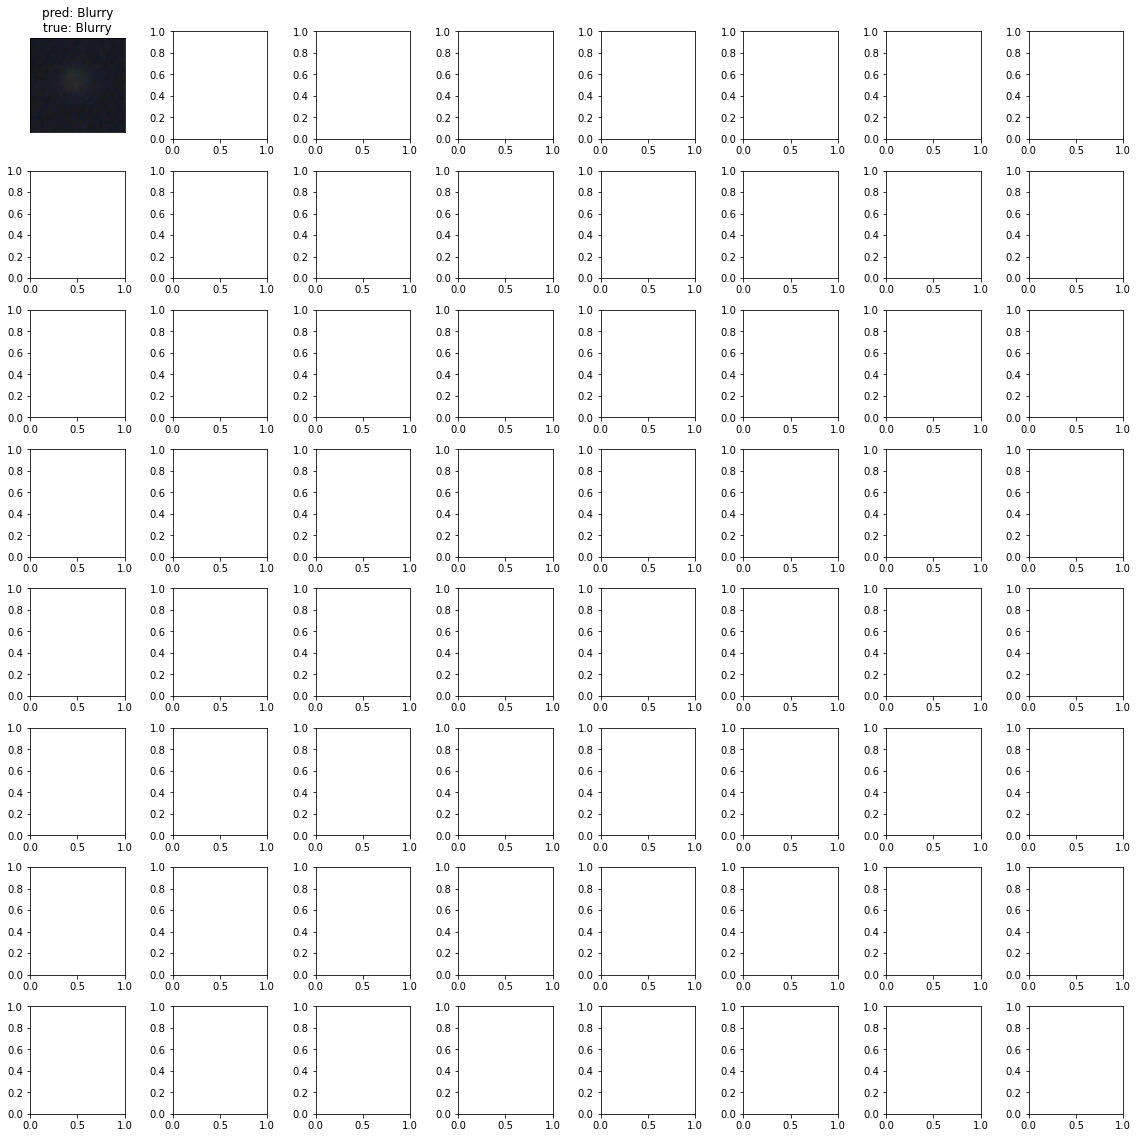

In [11]:
fig, axes = plt.subplots(figsize=(16, 16), ncols=8, nrows=8)
for i, img in enumerate(x):
    img = img.detach()
    img = to_pil_image(img)
    ax = axes.flatten()[i]
    ax.imshow(np.asarray(img))
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    ax.set_title(f"pred: {predicted_labels[i]}\ntrue: {true_labels[i]}")
plt.tight_layout()